In [105]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from numpy.random import seed
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from more_itertools import powerset

%matplotlib inline
%config InlineBackend.figure_format = 'svg'    

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

sns.set()
warnings.filterwarnings('ignore')
random_seed = 10000
seed(random_seed)

In [2]:
df = pd.read_csv('houses_dataset.csv', index_col = 'Id')
df = df._get_numeric_data()
df = df.dropna(axis='columns')
df_rows = df.shape[0]
zero_precents = df.astype(bool).apply(lambda x: ~x).sum(axis = 0) / df_rows
zero_columns_labels = list(zero_precents[zero_precents > 0.333].index)
df = df.drop(zero_columns_labels, axis = 1)
df = df.drop(['KitchenAbvGr'], axis = 1)
df.head(10)

MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                           
1           60     8450            7            5       2003          2003   
2           20     9600            6            8       1976          1976   
3           60    11250            7            5       2001          2002   
4           70     9550            7            5       1915          1970   
5           60    14260            8            5       2000          2000   
6           50    14115            5            5       1993          1995   
7           20    10084            8            5       2004          2005   
8           60    10382            7            6       1973          1973   
9           50     6120            7            5       1931          1950   
10         190     7420            5            6       1939          1950   

    BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  \
Id                                                                      
1          706        150          856       856       1710         2   
2          978        284         1262      1262       1262         2   
3          486        434          920       920       1786         2   
4          216        540          756       961       1717         1   
5          655        490         1145      1145       2198         2   
6          732         64          796       796       1362         1   
7         1369        317         1686      1694       1694         2   
8          859        216         1107      1107       2090         2   
9            0        952          952      1022       1774         2   
10         851        140          991      1077       1077         1   

    BedroomAbvGr  TotRmsAbvGrd  GarageCars  GarageArea  MoSold  YrSold  \
Id                                                                       
1              3             8           2         548       2    2008   
2              3             6           2         460       5    2007   
3              3             6           2         608       9    2008   
4              3             7           3         642       2    2006   
5              4             9           3         836      12    2008   
6              1             5           2         480      10    2009   
7              3             7           2         636       8    2007   
8              3             7           2         484      11    2009   
9              2             8           2         468       4    2008   
10             2             5           1         205       1    2008   

    SalePrice  
Id             
1      208500  
2      181500  
3      223500  
4      140000  
5      250000  
6      143000  
7      307000  
8      200000  
9      129900  
10     118000

## Correlation to Sale-Price

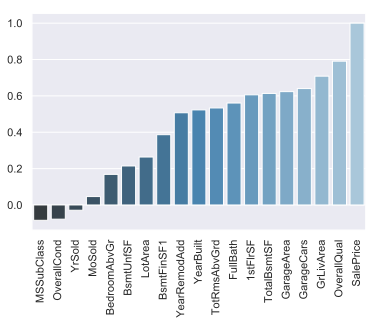

In [3]:
correlation = df.corr()['SalePrice'].sort_values()
dd = pd.DataFrame(correlation)
chart = sns.barplot(correlation.index, correlation.values, palette="Blues_d")
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [4]:
top_8_cats = abs(df.corr())['SalePrice'].sort_values(ascending=False)[1:(1+8)]
for cat in top_8_cats.index:
    print(cat)
data = df[list(top_8_cats.index) + ["SalePrice"]]

OverallQual
GrLivArea
GarageCars
GarageArea
TotalBsmtSF
1stFlrSF
FullBath
TotRmsAbvGrd


## Visualization

In [5]:
_ = sns.pairplot(data=data, y_vars=['SalePrice'], x_vars=data.columns, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'purple'}, 'scatter_kws': {'alpha': 0.2}})

# Correlation Heatmap

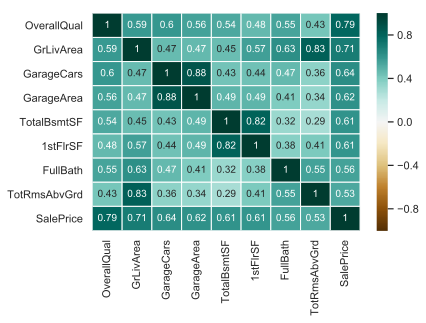

In [6]:
_ = sns.heatmap(data.corr(), cmap="BrBG", linewidths = 1, vmin = -1, vmax = 1, annot = True)

# Neural Network Training

In [7]:
test_precent = 0.15
train_precent = 1.0 - test_precent
train_data = data.sample(frac=train_precent, random_state=random_seed)
test_data = data.drop(train_data.index)

In [8]:
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
Id                                                                            
1356     0.643370   0.746126    0.291487    0.043976    -1.103240  0.130061   
1141    -0.801738  -1.073912    0.291487    1.708025    -0.254483 -0.554142   
491     -0.801738  -0.412080   -1.063329   -0.667841    -1.783135 -1.405594   
449     -0.079184  -0.276705   -1.063329   -1.318376    -0.636646 -0.990004   
358     -0.801738  -0.716673    0.291487    0.237251     0.167674 -0.072666   

      FullBath  TotRmsAbvGrd  SalePrice  
Id                                       
1356  2.583995      0.903746  -0.150385  
1141 -1.041486     -1.559842  -0.530158  
491  -1.041486     -1.559842  -0.824177  
449   0.771255      0.287849  -0.769048  
358  -1.041486     -0.328048  -0.591412

In [9]:
train_x = normalized_train_data.drop('SalePrice', axis = 1)
train_y = normalized_train_data['SalePrice']
test_x = normalized_test_data.drop('SalePrice', axis = 1)
test_y = normalized_test_data['SalePrice']

In [10]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(8, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(8, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)
   
    model = Model(input=[input_layer], output=[output_layer])
    last_layer_model = Model(input=[input_layer], output=[hidden_layer_2])
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    

    return model, last_layer_model

In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def trainModel(model, X, Y):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    history = model.fit(X, Y, epochs=400, validation_split = 0.33, verbose=0, callbacks=[PrintDot(), es, mc])
    model = load_model('best_nn_model.nn')
    return history, model

In [12]:
fully_NN_model, last_layer_NN_model = build_fully_NN_model(train_x)
fully_NN_history, fully_NN_model = trainModel(fully_NN_model, train_x, train_y)


....................................................................................................
............................................................

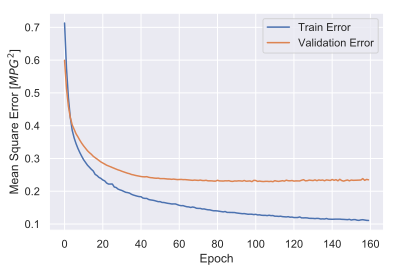

In [13]:
def plot_history(history):    
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch 
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Validation Error')
  #plt.ylim([0,1000])
  plt.legend()
  plt.show()

plot_history(fully_NN_history)

## Test Set

Test Set MSE = 0.14252491295337677


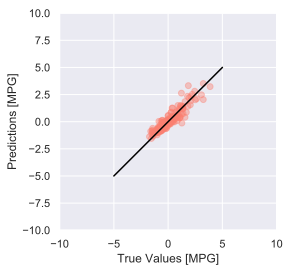

In [14]:
def show_test_predictions(name, model, test_X, test_Y):
    loss, mse = model.evaluate(test_X, test_Y, verbose=0)
    print(name + ' MSE = ' + str(mse))
    test_predictions = model.predict(test_X).flatten()

    plt.scatter(test_Y, test_predictions, alpha = 0.4, color = 'salmon')
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    _ = plt.plot([-5, 5], [-5, 5], color = 'black')
show_test_predictions('Test Set', fully_NN_model, test_x, test_y)

## Train Set

Train Set MSE = 0.15862925350666046


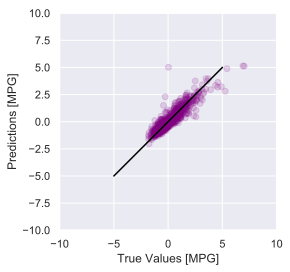

In [15]:
def show_test_predictions(name, model, testX, testY):
    loss, mse = model.evaluate(testX, testY, verbose=0)
    print(name + ' MSE = ' + str(mse))
    test_predictions = model.predict(testX).flatten()

    plt.scatter(testY, test_predictions, alpha = 0.15, color = 'purple')
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    _ = plt.plot([-5, 5], [-5, 5], color = 'black')
show_test_predictions('Train Set', fully_NN_model, train_x, train_y)

In [80]:
def evaluate(model, input_data):
    return model.predict(np.array([input_data]))[0][0]

def copy_and_add(data_list, dim_1, amount_1, dim_2, amount_2):
    data_list = data_list.copy()
    data_list[dim_1] += amount_1
    data_list[dim_2] += amount_2
    return data_list

def get_second_derivative(model, input_data, dim_1, dim_2):
    eps = 0.1
    f_pp = evaluate(model, copy_and_add(input_data, dim_1, eps, dim_2, eps))
    f_mm = evaluate(model, copy_and_add(input_data, dim_1, -eps, dim_2, -eps))
    f_mp = evaluate(model, copy_and_add(input_data, dim_1, -eps, dim_2, eps))
    f_pm = evaluate(model, copy_and_add(input_data, dim_1, eps, dim_2, -eps))
    real_sec_dev = (f_pp + f_mm - f_mp - f_pm) / (4*eps*eps)
    direction_dev = (f_pp - f_mm) / (4*eps*eps)
    mixed_direction_dev = (f_pm - f_mp) / (4*eps*eps)
    return real_sec_dev, direction_dev, mixed_direction_dev

def input_data_options(list_data):
    if (len(list_data) == 8):
        yield list_data
    else:
        for option in [0.3, 0.7]:
            list_data.append(option)
            for inner_res in input_data_options(list_data):
                yield inner_res
            list_data.pop()
sec_dev_table = np.zeros((8,8))
abs_sec_dev_table = np.zeros((8,8))
direction_dev_table = np.zeros((8,8))
abs_direction_dev_table = np.zeros((8,8))
mixed_direction_dev_table = np.zeros((8,8))
abs_mixed_direction_dev_table = np.zeros((8,8))
items_amount = 0
for input_data in input_data_options([]):
    items_amount += 1
    if (items_amount % 10 == 0):
        print('.', end='')
    for dim_1 in range(8):
        for dim_2 in range(8):
            real_sec_dev, direction_dev, mixed_direction_dev = get_second_derivative(fully_NN_model, input_data, dim_1, dim_2)
            sec_dev_table[dim_1, dim_2] += real_sec_dev
            abs_sec_dev_table[dim_1, dim_2] += abs(real_sec_dev)
            direction_dev_table[dim_1, dim_2] += direction_dev
            abs_direction_dev_table[dim_1, dim_2] += abs(direction_dev)
            mixed_direction_dev_table[dim_1, dim_2] += mixed_direction_dev
            abs_mixed_direction_dev_table[dim_1, dim_2] += abs(mixed_direction_dev)
sec_dev_table /= items_amount
abs_sec_dev_table /= items_amount
direction_dev_table /= items_amount
abs_direction_dev_table /= items_amount
mixed_direction_dev_table /= items_amount
abs_mixed_direction_dev_table /= items_amount

.........................

# Hessian f(x+e,y+e)+f(x-e,y-e)-f(x+e,y-e)-f(x-e,y+e)

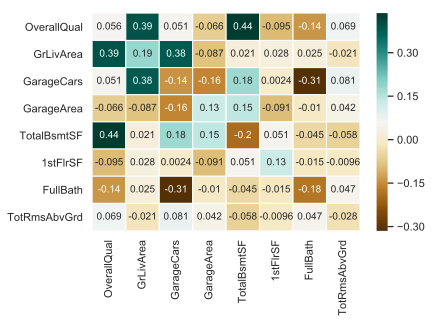

In [81]:
def to_df(hess_table):
    names = data.corr().columns[:8]
    hessian_df = pd.DataFrame(hess_table, index = names, columns=names)
    return hessian_df

def display_heatmap(hess):
    hessian_df = to_df(hess)
    min_val = hessian_df.min().min()
    max_val = hessian_df.max().max()
    _ = sns.heatmap(hessian_df, cmap="BrBG", linewidths = 1, vmin = min_val, vmax = max_val, annot = True)
display_heatmap(sec_dev_table)

# Absolute Hessian |f(x+e,y+e)+f(x-e,y-e)-f(x+e,y-e)-f(x-e,y+e)|

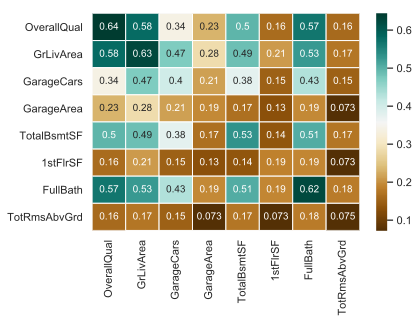

In [46]:
display_heatmap(abs_sec_dev_table)

# Directional Derivative f(x+e,y+e)-f(x-e,y-e)

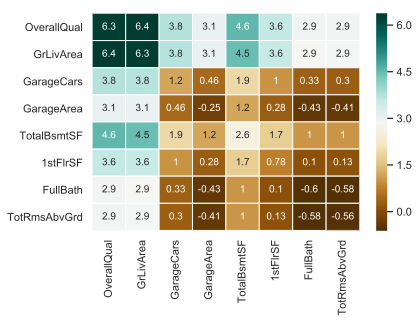

In [47]:
display_heatmap(direction_dev_table)

# Absolute Directional Derivative |f(x+e,y+e)-f(x-e,y-e)|

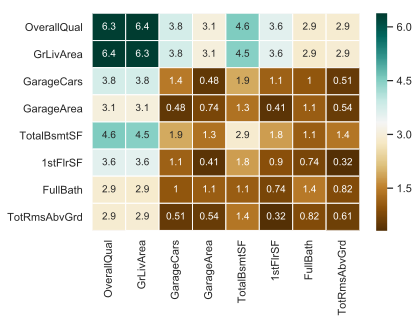

In [48]:
display_heatmap(abs_direction_dev_table)

# Mixed Directional Derivative f(x+e,y-e)-f(x-e,y+e)

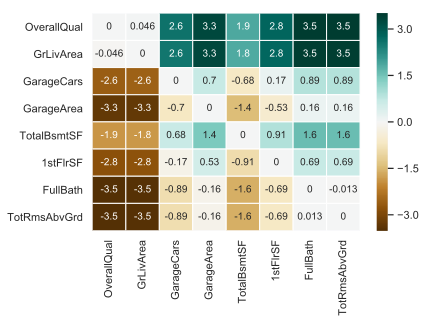

In [49]:
display_heatmap(mixed_direction_dev_table)

# Absolute Mixed Directional Derivative |f(x+e,y-e)-f(x-e,y+e)|

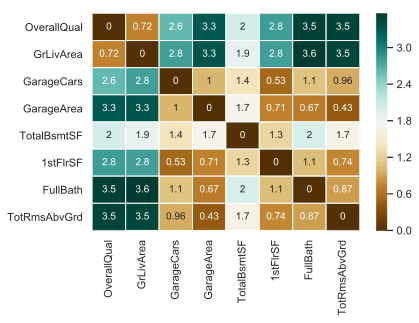

In [50]:
display_heatmap(abs_mixed_direction_dev_table)

# Prametric-Rank-Sum

In [94]:
def perform_parametric_rank_sum(hess, name):
    hess = to_df(hess)
    n_inputs = hess.shape[0]
    inputs = set(hess.columns)
    partitions = [(set(partition), inputs - set(partition))
                      for partition in powerset(inputs)
                      if len(partition) >=2 and len(partition) <= n_inputs - 2 and 'OverallQual' in partition]
    
    def extract_triangle(cols):
        data = hess.loc[cols, cols]
        data = data.where(np.triu(np.ones(data.shape)).astype(bool)).stack().to_numpy()
        return data
    
    triangular_samples = [((group1, extract_triangle(group1)), (group2, extract_triangle(group2)))
                          for group1, group2 in partitions]
    rank_sum_pvalues = [(g1, g2, ranksums(x=g1_data, y=g2_data).pvalue)
                        for ((g1, g1_data), (g2, g2_data)) in triangular_samples]
    pvalues = list(map(lambda c: c[2], rank_sum_pvalues))
    alpha = 0.05
    rank_sum_pvalues_adj = multipletests(pvals=pvalues, is_sorted = False, method = 'holm-sidak', alpha = alpha)[1]
    results = [(tuple(g1), tuple(g2), orig_pval)
               for ((g1, g2, orig_pval), adj_pval) in zip(rank_sum_pvalues, rank_sum_pvalues_adj)]
    sorted_results = list(sorted(results, key = lambda x: x[2]))
    sorted_results = [sorted_results[i] + ((i + 1,)) for i in range(len(sorted_results))]
    return pd.DataFrame(sorted_results, columns=['group1', 'group2', name+'_pvalue', name+'_pvalue_rank'])

# Prametric-Rank-Sum Absolute Hessian

In [95]:
sec_dev_table_rank_sum = perform_parametric_rank_sum(sec_dev_table,'dv_dv')
abs_sec_dev_table_rank_sum = perform_parametric_rank_sum(abs_sec_dev_table,'|dv_dv|')
direction_dev_table_rank_sum = perform_parametric_rank_sum(direction_dev_table,'dir_dv')
abs_direction_dev_table_rank_sum = perform_parametric_rank_sum(abs_direction_dev_table,'|dir_dv|')
mixed_direction_dev_table_rank_sum = perform_parametric_rank_sum(mixed_direction_dev_table,'mixed_dir')
abs_mixed_direction_dev_table_rank_sum = perform_parametric_rank_sum(abs_mixed_direction_dev_table,'|mixed_dir|')

# Prametric-Rank-Sum Hessian

In [109]:
merged_parametric_rank_sum = \
    sec_dev_table_rank_sum.merge(abs_sec_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(abs_direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(mixed_direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(abs_mixed_direction_dev_table_rank_sum, on=['group1','group2'], how='inner')

In [110]:
merged_parametric_rank_sum

group1                                                                    group2  dv_dv_pvalue  dv_dv_pvalue_rank  |dv_dv|_pvalue  |dv_dv|_pvalue_rank  dir_dv_pvalue  dir_dv_pvalue_rank  |dir_dv|_pvalue  |dir_dv|_pvalue_rank  mixed_dir_pvalue  mixed_dir_pvalue_rank  |mixed_dir|_pvalue  |mixed_dir|_pvalue_rank
0    (1stFlrSF, GrLivArea, OverallQual, TotalBsmtSF, GarageArea, TotRmsAbvGrd)    (FullBath, GarageCars)                                                    0.010025      1                  0.126630        51                   0.088737       49                  0.406975         85                    0.205633          17                     0.176071            19                     
1    (GrLivArea, OverallQual)                                                     (1stFlrSF, FullBath, GarageCars, TotalBsmtSF, GarageArea, TotRmsAbvGrd)   0.020717      2                  0.007762        15                   0.005968       15                  0.005968         17                    0.631171          78                     0.176071            18                     
2    (1stFlrSF, GrLivArea, OverallQual, GarageCars, GarageArea, TotRmsAbvGrd)     (TotalBsmtSF, FullBath)                                                   0.026026      3                  0.040243        36                   0.275234       70                  0.694473         101                   0.827259          104                    0.275234            30                     
3    (1stFlrSF, GrLivArea, OverallQual, GarageArea, TotRmsAbvGrd)                 (TotalBsmtSF, FullBath, GarageCars)                                       0.029273      4                  0.029273        30                   0.212912       64                  0.483522         87                    0.668524          84                     0.413686            43                     
4    (GrLivArea, OverallQual, GarageCars)                                         (1stFlrSF, FullBath, TotalBsmtSF, GarageArea, TotRmsAbvGrd)               0.042960      5                  0.006435        13                   0.001077       5                   0.000815         6                     0.559305          67                     0.968950            114                    
5    (1stFlrSF, GrLivArea, OverallQual, TotalBsmtSF, TotRmsAbvGrd)                (GarageArea, FullBath, GarageCars)                                        0.051625      6                  0.391805        80                   0.006435       17                  0.029273         34                    0.413686          50                     0.149804            14                     
6    (TotalBsmtSF, GrLivArea, OverallQual)                                        (1stFlrSF, FullBath, GarageCars, GarageArea, TotRmsAbvGrd)                0.073366      7                  0.001414        5                    0.000460       3                   0.000460         3                     0.079839          8                      0.907038            97                     
7    (TotalBsmtSF, GrLivArea, OverallQual, GarageCars)                            (TotRmsAbvGrd, 1stFlrSF, GarageArea, FullBath)                            0.082099      8                  0.001499        6                    0.000157       1                   0.000157         1                     0.820596          103                    0.256839            23                     
8    (1stFlrSF, GrLivArea, OverallQual)                                           (FullBath, GarageCars, TotalBsmtSF, GarageArea, TotRmsAbvGrd)             0.086768      9                  0.212912        61                   0.002396       8                   0.005069         14                    0.149804          14                     0.968950            110                    
9    (1stFlrSF, GrLivArea, OverallQual, TotalBsmtSF, GarageArea)                  (TotRmsAbvGrd, FullBath, GarageCars)                                      0.086768      10                 0.533417        89                 